In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted,realsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
pwd

'/Users/tizi/Documents/YALE_WL.nosync/purity-monitor/Jupyter/Log'

In [3]:
#plt.style.use('style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#File Paths for PDE measurement at 4V OV
#NO_FIELD='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_PDE/'
#POS_FIELD='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_PDE/'
#NEG_FIELD='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_PDE/'
NO_FIELD = r'/Users/tizi/Documents/YALE_WL.nosync/data/Avinay/NO_FIELD/'
POS_FIELD = r'/Users/tizi/Documents/YALE_WL.nosync/data/Avinay/POS_FIELD/'
NEG_FIELD = r'/Users/tizi/Documents/YALE_WL.nosync/data/Avinay/NEG_FIELD/'

In [5]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [6]:
def rebin_center(hx,h,bins):
    h_rebin=[]
    hx_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
        hx_rebin.append(np.mean(hx[start_idx:end_idx]))
    # hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [7]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [8]:
def line(x,a,b):
    return a*(x-b)

In [9]:
def gain_calculator(PATH,N_BINS,N_PEAKS):

    BINS=N_BINS #Number of bins to rebin the MCA data with
    N_peaks= N_PEAKS# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function
    calib_pe=[]#empty list to fill in the values for calibrated PE 
    calib_count=[]
    Files = glob.glob(PATH+'*mca*.h5')
    #for loop to loop over all the files
    for i,file in enumerate(natsorted(Files)):
        print(file) 
    
    
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df[250:]
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)
        

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=80/BINS)
        peak_length=len(peaks)
        #We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=80/BINS)
            peak_length=len(peaks)
 
        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[0]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[0]] # The height of the 3rd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

       
        plt.figure(figsize=(12,2)) # Call the figure here
        plt.subplot(1,3,1) #This subplot will plot the position of the peaks and also the data
        plt.xlim(0,1000/BINS)
        # plt.ylim(0,50)
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.plot(hx,h,lw=1) #plot the signal
        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        print(popt)
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        
        
            
        
        
        
        for i,peak in enumerate(peaks[2:]): #here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] #x-value of the peak
            new_max_value=h[peak] #height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 

        plt.subplot(1,3,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        if (h[peaks[2]]/BINS<90): 
            popt_temp,pcov_temp=curve_fit(line,np.arange(3,len(peaks)+1),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
            plt.plot(np.arange(3,len(peaks)+1),line(np.arange(3,len(peaks)+1),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit

            plt.scatter(np.arange(3,len(peaks)+1),gain_temp,color='r') #plot the values of the peak means
            plt.legend(loc=2)

        else:
            popt_temp,pcov_temp=curve_fit(line,np.arange(2,len(peaks)),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
            plt.plot(np.arange(2,len(peaks)),line(np.arange(2,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
            plt.scatter(np.arange(2,len(peaks)),gain_temp,color='r') #plot the values of the peak means
            plt.legend(loc=2)


        print(gain_temp)
  
        
        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit

        calib_pe.append(hx/popt_temp[0]+popt_temp[1])
        calib_count.append(h)
        plt.subplot(1,3,3)#This subplot shows the calibrated PE spectra
        plt.plot(hx/popt_temp[0]+popt_temp[1],h)
        plt.yscale('log')
        plt.xlim(0,5)
        plt.xticks(np.arange(0,5))
        plt.grid()
        plt.show() #show the plot

    return(np.array(calib_pe),np.array(calib_count),np.array(gain_list),np.array(gain_err))

In [ ]:
NO_FIELD_calib_pe,NO_FIELD_calib_count,NO_FIELD_gain_list,NO_FIELD_gain_err=gain_calculator(NO_FIELD,9,4)

In [ ]:
NO_FIELD_pe_corrected_gain=[]
NO_FIELD_pe_corrected_gain_err=[]
NO_FIELD_calib_pe_updated=[]

for x,y in zip(NO_FIELD_calib_pe,NO_FIELD_calib_count):
    plt.figure(figsize=(12,2))
    plt.subplot(1,3,1)
    plt.plot(x,y)
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')
    
    
    N_peaks=4
    PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
    peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
    peak_length=len(peaks)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
    while (peak_length<N_peaks+1):
        PROMINENCE=PROMINENCE-1
            
        peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
        peak_length=len(peaks)


        
    plt.plot(x[peaks],y[peaks],'*',ms=5) # plot the peak markers
    first_pe_max=x[peaks[2]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
    max_value=y[peaks[2]] # The height of the 3rd peak
    x_idx_array=(y<0.5*max_value) & (x>first_pe_max)# returns a boolean array where both conditions are true
    right_side_x= x[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
    sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks
    cut= (x < first_pe_max+sigma_guess) & (x > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
    popt,pcov=curve_fit(gauss,x[cut],y[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
    plt.plot(x[cut],gauss(x[cut],*popt),color='r',label='Fit',lw=2) # Here we plot the fit on the 2nd peak to see if everything looks ok.
    
    params_pe = []
    params_pe_count=[]
    for i,peak in enumerate(peaks[2:]): #here we ignore the first peak because it could be the pedestal
        new_first_pe_max=x[peak] #x-value of the peak
        new_max_value=y[peak] #height of the peak
        new_x_idx_array=(y<0.5*new_max_value) & (x>new_first_pe_max) # returns a boolean array where both conditions are true
        new_right_side_x= x[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


        new_cut= (x < new_first_pe_max+new_sigma_guess) & (x > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
        popt_new,pcov_new=curve_fit(gauss,x[new_cut],y[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(x[new_cut],gauss(x[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
        params_pe.append(popt_new[1]) #Here we append the value of the peak fit mean 
        params_pe_count.append((x[peak]))

    plt.subplot(1,3,2) 
    
    plt.scatter(params_pe_count, np.array(params_pe), s=10, zorder=10)
    popt_line,pcov_line = curve_fit(line, params_pe_count, np.array(params_pe), p0=[10,0])
    print(params_pe_count)
    print(popt_line)
    plt.plot(params_pe_count, line(params_pe_count, *popt_line), color=colors[1], label='Gain: {:.2f} ADC/p.e.'.format(popt_line[0]))
    NO_FIELD_pe_corrected_gain.append(popt_line[0])
    NO_FIELD_pe_corrected_gain_err.append(np.sqrt(np.diag(pcov_line)[0]))
    plt.legend(loc=2)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Counts')



    plt.subplot(1,3,3)
    NO_FIELD_calib_pe_updated.append(x/popt_line[0])
    plt.step(x/popt_line[0],y)
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')



    plt.tight_layout()
    plt.show()

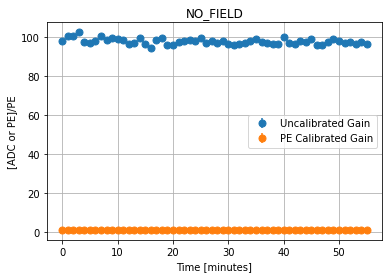

In [12]:
plt.figure(figsize=(6,4))
time_NO_FIELD=np.arange(0,len(NO_FIELD_calib_pe))
plt.errorbar(time_NO_FIELD,NO_FIELD_gain_list*9,yerr=NO_FIELD_gain_err,fmt='o',ms=7,label='Uncalibrated Gain')
plt.errorbar(time_NO_FIELD,NO_FIELD_pe_corrected_gain,yerr=NO_FIELD_pe_corrected_gain_err,fmt='o',ms=7,label='PE Calibrated Gain')

plt.ylabel('[ADC or PE]/PE')
plt.xlabel('Time [minutes]')
plt.title('NO_FIELD')
plt.grid()
plt.legend(loc='best')
#plt.savefig('NO_FIELD_gain_comparison.pdf')
plt.show()

In [ ]:
POS_FIELD_calib_pe,POS_FIELD_calib_count,POS_FIELD_gain_list,POS_FIELD_gain_err=gain_calculator(POS_FIELD,10,4)

In [ ]:
POS_FIELD_pe_corrected_gain=[]
POS_FIELD_pe_corrected_gain_err=[]
POS_FIELD_calib_pe_updated=[]
for x,y in zip(POS_FIELD_calib_pe,POS_FIELD_calib_count):
    plt.figure(figsize=(12,2))
    plt.subplot(1,3,1)
    plt.step(x,y)
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')
    
    
    N_peaks=4
    PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
    peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
    peak_length=len(peaks)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
    while (peak_length<N_peaks+1):
        PROMINENCE=PROMINENCE-1
            
        peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
        peak_length=len(peaks)


        
    plt.plot(x[peaks],y[peaks],'*',ms=5) # plot the peak markers
    first_pe_max=x[peaks[2]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
    max_value=y[peaks[2]] # The height of the 3rd peak
    x_idx_array=(y<0.5*max_value) & (x>first_pe_max)# returns a boolean array where both conditions are true
    right_side_x= x[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
    sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks
    cut= (x < first_pe_max+sigma_guess) & (x > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
    popt,pcov=curve_fit(gauss,x[cut],y[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
    plt.plot(x[cut],gauss(x[cut],*popt),color='r',label='Fit',lw=2) # Here we plot the fit on the 2nd peak to see if everything looks ok.
    
    params_pe = []
    params_pe_count=[]
    for i,peak in enumerate(peaks[2:]): #here we ignore the first peak because it could be the pedestal
        new_first_pe_max=x[peak] #x-value of the peak
        new_max_value=y[peak] #height of the peak
        new_x_idx_array=(y<0.5*new_max_value) & (x>new_first_pe_max) # returns a boolean array where both conditions are true
        new_right_side_x= x[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


        new_cut= (x < new_first_pe_max+new_sigma_guess) & (x > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
        popt_new,pcov_new=curve_fit(gauss,x[new_cut],y[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(x[new_cut],gauss(x[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
        params_pe.append(popt_new[1]) #Here we append the value of the peak fit mean 
        params_pe_count.append((x[peak]))

    plt.subplot(1,3,2) 
    
    plt.scatter(params_pe_count, np.array(params_pe), s=10, zorder=10)
    popt_line,pcov_line = curve_fit(line, params_pe_count, np.array(params_pe), p0=[10,0])
    plt.plot(params_pe_count, line(params_pe_count, *popt_line), color=colors[1], label='Gain: {:.2f} ADC/p.e.'.format(popt_line[0]))
    POS_FIELD_pe_corrected_gain.append(popt_line[0])
    POS_FIELD_pe_corrected_gain_err.append(np.sqrt(np.diag(pcov_line)[0]))
    plt.legend(loc=2)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Counts')

    plt.subplot(1,3,3)
    plt.plot(x/popt_line[0],y)
    POS_FIELD_calib_pe_updated.append(x/popt_line[0])
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')


    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(6,4))
time_POS_FIELD=np.arange(0,len(POS_FIELD_gain_list))

plt.errorbar(time_POS_FIELD,POS_FIELD_gain_list*10,yerr=POS_FIELD_gain_err,fmt='o',ms=7,label='Uncalibrated Gain')
plt.errorbar(time_POS_FIELD,POS_FIELD_pe_corrected_gain,yerr=POS_FIELD_pe_corrected_gain_err,fmt='o',ms=7,label='PE Calibrated Gain')

plt.ylabel('[ADC or PE]/PE')
plt.xlabel('Time [minutes]')
plt.title('POS_FIELD')
plt.grid()
plt.legend(loc='best')
plt.savefig('POS_FIELD_gain_comparison.pdf')
plt.show()

In [ ]:
NEG_FIELD_calib_pe,NEG_FIELD_calib_count,NEG_FIELD_gain_list,NEG_FIELD_gain_err=gain_calculator(NEG_FIELD,11,4)

In [ ]:
NEG_FIELD_pe_corrected_gain=[]
NEG_FIELD_pe_corrected_gain_err=[]
NEG_FIELD_calib_pe_updated=[]

for x,y in zip(NEG_FIELD_calib_pe,NEG_FIELD_calib_count):
    plt.figure(figsize=(12,2))
    plt.subplot(1,3,1)
    plt.step(x,y)
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')
    
    
    N_peaks=4
    PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
    peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
    peak_length=len(peaks)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
    while (peak_length<N_peaks+1):
        PROMINENCE=PROMINENCE-1
            
        peaks,pdict=find_peaks(y,prominence=PROMINENCE,distance=5)
        peak_length=len(peaks)


        
    plt.plot(x[peaks],y[peaks],'*',ms=5) # plot the peak markers
    first_pe_max=x[peaks[2]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
    max_value=y[peaks[2]] # The height of the 3rd peak
    x_idx_array=(y<0.5*max_value) & (x>first_pe_max)# returns a boolean array where both conditions are true
    right_side_x= x[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
    sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks
    cut= (x < first_pe_max+sigma_guess) & (x > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
    popt,pcov=curve_fit(gauss,x[cut],y[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
    plt.plot(x[cut],gauss(x[cut],*popt),color='r',label='Fit',lw=2) # Here we plot the fit on the 2nd peak to see if everything looks ok.
    
    params_pe = []
    params_pe_count=[]
    for i,peak in enumerate(peaks[2:]): #here we ignore the first peak because it could be the pedestal
        new_first_pe_max=x[peak] #x-value of the peak
        new_max_value=y[peak] #height of the peak
        new_x_idx_array=(y<0.5*new_max_value) & (x>new_first_pe_max) # returns a boolean array where both conditions are true
        new_right_side_x= x[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


        new_cut= (x < new_first_pe_max+new_sigma_guess) & (x > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
        popt_new,pcov_new=curve_fit(gauss,x[new_cut],y[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(x[new_cut],gauss(x[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
        params_pe.append(popt_new[1]) #Here we append the value of the peak fit mean 
        params_pe_count.append((x[peak]))

    plt.subplot(1,3,2) 
    
    plt.scatter(params_pe_count, np.array(params_pe), s=10, zorder=10)
    popt_line,pcov_line = curve_fit(line, params_pe_count, np.array(params_pe), p0=[10,0])
    plt.plot(params_pe_count, line(params_pe_count, *popt_line), color=colors[1], label='Gain: {:.2f} ADC/p.e.'.format(popt_line[0]))
    NEG_FIELD_pe_corrected_gain.append(popt_line[0])
    NEG_FIELD_pe_corrected_gain_err.append(np.sqrt(np.diag(pcov_line)[0]))
    plt.legend(loc=2)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Counts')


    plt.subplot(1,3,3)
    plt.plot(x/popt_line[0],y)
    NEG_FIELD_calib_pe_updated.append(x/popt_line[0])
    plt.yscale('log')
    plt.xlim(0,10)
    plt.grid()
    plt.xlabel('PE')
    plt.ylabel('Count')


    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(6,4))
time_NEG_FIELD=np.arange(0,len(NEG_FIELD_gain_list))

plt.errorbar(time_NEG_FIELD,NEG_FIELD_gain_list*11,yerr=NEG_FIELD_gain_err,fmt='o',ms=7,label='Uncalibrated Gain')
plt.errorbar(time_NEG_FIELD,NEG_FIELD_pe_corrected_gain,yerr=NEG_FIELD_pe_corrected_gain_err,fmt='o',ms=7,label='PE Calibrated Gain')

plt.ylabel('[ADC or PE]/PE')
plt.xlabel('Time [minutes]')
plt.title('NEG_FIELD')
plt.grid()
plt.legend(loc='best')
plt.savefig('NEG_FIELD_gain_comparison.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(5,4))
plt.errorbar(1,np.mean(NO_FIELD_gain_list*9),yerr=np.std(NO_FIELD_gain_list*9),label='NO FIELD',fmt='o')
plt.errorbar(5,np.mean(POS_FIELD_gain_list*10),yerr=np.std(POS_FIELD_gain_list*10),label='POS FIELD',fmt='o')
plt.errorbar(10,np.mean(NEG_FIELD_gain_list*11),yerr=np.std(NEG_FIELD_gain_list*11),label='NEG FIELD',fmt='o')
plt.legend(loc='best')
plt.xlim(0,12)
plt.xlabel('')
plt.ylabel('Gain[ADC/PE]')
plt.grid()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('gain_comparison.pdf')
plt.show()

print((np.mean(POS_FIELD_gain_list*10)-np.mean(NO_FIELD_gain_list*9))/(np.mean(NO_FIELD_gain_list*9))*100,'%')
print((np.mean(NEG_FIELD_gain_list*11)-np.mean(NO_FIELD_gain_list*9))/(np.mean(NO_FIELD_gain_list*9))*100,'%')

In [ ]:
frac_POS=(np.mean(POS_FIELD_gain_list*10)/np.mean(NO_FIELD_gain_list*9))
frac_NEG=(np.mean(NEG_FIELD_gain_list*11)/np.mean(NO_FIELD_gain_list*9))

In [ ]:
correction_factor=0.99

avg_NO_FIELD=0
avg_POS_FIELD=0
avg_NEG_FIELD=0
plt.figure(figsize=(15,10))
n_bins=1


#--------- NO_FIELD  ------------
for i in range(len(NO_FIELD_calib_pe)):
    x_NO_FIELD,y_NO_FIELD=rebin_center(NO_FIELD_calib_pe[i]*correction_factor,NO_FIELD_calib_count[i],n_bins)
    avg_NO_FIELD+=y_NO_FIELD
    
rate_NO_FIELD=avg_NO_FIELD/(60*len(time_NO_FIELD))
cut_NO_FIELD=np.where((x_NO_FIELD>40) & (x_NO_FIELD<100))
popt_NO_FIELD,pcov_NO_FIELD=curve_fit(gauss,x_NO_FIELD[cut_NO_FIELD],rate_NO_FIELD[cut_NO_FIELD],p0=[np.max(rate_NO_FIELD[cut_NO_FIELD]),65,80],maxfev=100000)

#--------- POS_FIELD  ------------

for i in range(len(POS_FIELD_calib_pe_updated)):
    x_POS_FIELD,y_POS_FIELD=rebin_center(POS_FIELD_calib_pe[i]*correction_factor,POS_FIELD_calib_count[i],n_bins)
    avg_POS_FIELD+=y_POS_FIELD
    
rate_POS_FIELD=avg_POS_FIELD/(60*len(time_POS_FIELD))
cut_POS_FIELD=np.where((x_POS_FIELD>25) & (x_POS_FIELD<70))
cut_POS_FIELD_frac=np.where((x_POS_FIELD>25*frac_POS) & (x_POS_FIELD<70*frac_POS))
popt_POS_FIELD,pcov_POS_FIELD=curve_fit(gauss,x_POS_FIELD[cut_POS_FIELD],rate_POS_FIELD[cut_POS_FIELD],p0=[np.max(rate_POS_FIELD[cut_POS_FIELD]),65,80],maxfev=100000)
popt_POS_FIELD_frac,pcov_POS_FIELD_frac=curve_fit(gauss,x_POS_FIELD[cut_POS_FIELD_frac],rate_POS_FIELD[cut_POS_FIELD_frac],p0=[np.max(rate_POS_FIELD[cut_POS_FIELD_frac]),65**frac_POS,80],maxfev=100000)


#--------- NEG_FIELD  ------------

for i in range(len(NEG_FIELD_calib_pe)):
    x_NEG_FIELD,y_NEG_FIELD=rebin_center(NEG_FIELD_calib_pe[i]*correction_factor,NEG_FIELD_calib_count[i],n_bins)
    avg_NEG_FIELD+=y_NEG_FIELD
    
rate_NEG_FIELD=avg_NEG_FIELD/(60*len(time_NEG_FIELD))
cut_NEG_FIELD=np.where((x_NEG_FIELD>25) & (x_NEG_FIELD<70))
popt_NEG_FIELD,pcov_NEG_FIELD=curve_fit(gauss,x_NEG_FIELD[cut_NEG_FIELD],rate_NEG_FIELD[cut_NEG_FIELD],p0=[np.max(rate_NEG_FIELD[cut_NEG_FIELD]),65,80],maxfev=100000)
cut_NEG_FIELD_frac=np.where((x_NEG_FIELD>25*frac_NEG) & (x_NEG_FIELD<70*frac_NEG))
popt_NEG_FIELD_frac,pcov_NEG_FIELD_frac=curve_fit(gauss,x_NEG_FIELD[cut_NEG_FIELD_frac],
                                                  rate_NEG_FIELD[cut_NEG_FIELD_frac],
                                                  p0=[np.max(rate_NEG_FIELD[cut_NEG_FIELD_frac]),65**frac_NEG,80]
                                                  ,maxfev=100000)





plt.subplot(2,2,1)
plt.plot(x_NO_FIELD,rate_NO_FIELD,lw=3,label='No E Field')
plt.plot(x_POS_FIELD,rate_POS_FIELD,lw=3,label='Pos E Field')
plt.plot(x_NEG_FIELD,rate_NEG_FIELD,lw=3,label='Neg E Field')
plt.xlabel('PE [Normalized to self]')
plt.ylabel('Rate [Hz]')





N_peaks=10


#--------- NO_FIELD  ------------

PROMINENCE_NO_FIELD=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
peaks_NO_FIELD,pdict_NO_FIELD=find_peaks(rate_NO_FIELD,prominence=PROMINENCE_NO_FIELD)
peak_length_NO_FIELD=len(peaks_NO_FIELD)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
while (peak_length_NO_FIELD<N_peaks+1):
    PROMINENCE_NO_FIELD=PROMINENCE_NO_FIELD-1
            
    peaks_NO_FIELD,pdict_NO_FIELD=find_peaks(rate_NO_FIELD,prominence=PROMINENCE_NO_FIELD)
    peak_length_NO_FIELD=len(peaks_NO_FIELD)
# plt.plot(x_NO_FIELD[peaks_NO_FIELD],rate_NO_FIELD[peaks_NO_FIELD],'*',ms=7) # plot the peak markers



#--------- POS_FIELD  ------------

PROMINENCE_POS_FIELD=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
peaks_POS_FIELD,pdict_POS_FIELD=find_peaks(rate_POS_FIELD,prominence=PROMINENCE_POS_FIELD)
peak_length_POS_FIELD=len(peaks_POS_FIELD)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
while (peak_length_POS_FIELD<N_peaks+1):
    PROMINENCE_POS_FIELD=PROMINENCE_POS_FIELD-1
            
    peaks_POS_FIELD,pdict_POS_FIELD=find_peaks(rate_POS_FIELD,prominence=PROMINENCE_POS_FIELD)
    peak_length_POS_FIELD=len(peaks_POS_FIELD)
# plt.plot(x_POS_FIELD[peaks_POS_FIELD],rate_POS_FIELD[peaks_POS_FIELD],'*',ms=7) # plot the peak markers


#--------- NEG_FIELD  ------------


PROMINENCE_NEG_FIELD=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
peaks_NEG_FIELD,pdict_NEG_FIELD=find_peaks(rate_NEG_FIELD,prominence=PROMINENCE_NEG_FIELD)
peak_length_NEG_FIELD=len(peaks_NEG_FIELD)
    
#     We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
while (peak_length_NEG_FIELD<N_peaks+1):
    PROMINENCE_NEG_FIELD=PROMINENCE_NEG_FIELD-1
            
    peaks_NEG_FIELD,pdict_NEG_FIELD=find_peaks(rate_NEG_FIELD,prominence=PROMINENCE_NEG_FIELD)
    peak_length_NEG_FIELD=len(peaks_NEG_FIELD)
# plt.plot(x_NEG_FIELD[peaks_NEG_FIELD],rate_NEG_FIELD[peaks_NEG_FIELD],'*',ms=7) # plot the peak markers




plt.grid()
plt.xlim(0,15)
plt.ylim(0.2,1E3)
plt.yscale('log')
plt.legend(loc='best')


plt.subplot(2,2,2)
plt.plot(x_NO_FIELD,rate_NO_FIELD,color=colors[0],label='No E Field')
plt.plot(x_NO_FIELD[cut_NO_FIELD],gauss(x_NO_FIELD[cut_NO_FIELD],*popt_NO_FIELD),'m-.',lw=5,label="$\mu$: "+str(np.round(popt_NO_FIELD[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_NO_FIELD)[1]),2)))


plt.plot(x_POS_FIELD,rate_POS_FIELD,color=colors[1],label='Pos E Field')
plt.plot(x_POS_FIELD[cut_POS_FIELD],gauss(x_POS_FIELD[cut_POS_FIELD],*popt_POS_FIELD),'k-.',lw=5,label="$\mu$: "+str(np.round(popt_POS_FIELD[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_POS_FIELD)[1]),2)))


plt.plot(x_NEG_FIELD,rate_NEG_FIELD,color=colors[2],label='Neg E Field')
plt.plot(x_NEG_FIELD[cut_NEG_FIELD],gauss(x_NEG_FIELD[cut_NEG_FIELD],*popt_NEG_FIELD),'r-.',lw=5,label="$\mu$: "+str(np.round(popt_NEG_FIELD[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_NEG_FIELD)[1]),2)))

plt.xlim(10,150)
plt.ylim(0,0.3)
plt.legend(loc='best')
plt.grid()
plt.xlabel('PE [Normalized to self]')
plt.ylabel('Rate [Hz]')

plt.subplot(2,2,3)
plt.plot(x_NO_FIELD,rate_NO_FIELD,lw=3,label='No E Field')
plt.plot(x_POS_FIELD*frac_POS,rate_POS_FIELD,lw=3,label='Pos E Field')
plt.plot(x_NEG_FIELD*frac_NEG,rate_NEG_FIELD,lw=3,label='Neg E Field')
plt.grid()
plt.xlim(0,15)
plt.ylim(0.2,1E3)
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('PE [Normalized to E=0 V/cm]')
plt.ylabel('Rate [Hz]/'+str(np.round(x_NO_FIELD[1]-x_NO_FIELD[0],1))+'PE')

plt.subplot(2,2,4)
plt.plot(x_NO_FIELD,rate_NO_FIELD,color=colors[0],label='No E Field')
plt.plot(x_NO_FIELD[cut_NO_FIELD],gauss(x_NO_FIELD[cut_NO_FIELD],*popt_NO_FIELD),'m-.',lw=5,label="$\mu$: "+str(np.round(popt_NO_FIELD[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_NO_FIELD)[1]),2)))


plt.plot(x_POS_FIELD*frac_POS,rate_POS_FIELD,color=colors[1],label='Pos E Field')
plt.plot(x_POS_FIELD[cut_POS_FIELD_frac]*frac_POS,gauss(x_POS_FIELD[cut_POS_FIELD_frac],*popt_POS_FIELD_frac),'k-.',lw=5,label="$\mu$: "+str(np.round(popt_POS_FIELD_frac[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_POS_FIELD_frac)[1]),2)))


plt.plot(x_NEG_FIELD*frac_NEG,rate_NEG_FIELD,color=colors[2],label='Neg E Field')
plt.plot(x_NEG_FIELD[cut_NEG_FIELD_frac]*frac_NEG,gauss(x_NEG_FIELD[cut_NEG_FIELD_frac],*popt_NEG_FIELD_frac),'r-.',lw=5,label="$\mu$: "+str(np.round(popt_NEG_FIELD_frac[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_NEG_FIELD_frac)[1]),2)))




plt.xlim(10,150)
plt.ylim(0,0.3)
# plt.yscale('log')
plt.legend(loc='best')
plt.grid()
plt.xlabel('PE [Normalized to E=0 V/cm]')
plt.ylabel('Rate [Hz]/'+str(np.round(x_NO_FIELD[1]-x_NO_FIELD[0],1))+'PE')
plt.tight_layout()

plt.savefig('Source_PDE.pdf')
plt.show()

print(x_NO_FIELD[1]-x_NO_FIELD[0],x_POS_FIELD[1]-x_POS_FIELD[0],x_NEG_FIELD[1]-x_NEG_FIELD[0])
